In [ ]:

# 人脸检测模型导出
import paddlehub as hub

# 加载模型
face_detector = hub.Module(name="pyramidbox_lite_server_mask")

# 导出推理模型
face_detector.save_inference_model(
    dirname='inference/face_detect',
    model_filename='__model__',
    params_filename='__params__')

In [ ]:


# 新建临时train.txt
#with open('/home/rogerle/PycharmProjects/WonkerAIMan/data/waves/train_list.txt', 'w', encoding='UTF-8') as f:
#    for x in range(37):
#        f.write('{:04d}.jpg 0\n'.format(x+1))

import os
from typing import Callable, Tuple

import paddle
import numpy as np
import paddlehub as hub
import paddlehub.vision.transforms as T
from paddlehub.finetune import Trainer

#定义数据预处理方式
transforms = T.Compose([T.Resize((256, 256)),
                        T.CenterCrop(224),
                        T.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])],
                        to_rgb=True)
# 自定义数据集
class FaceDataset(paddle.io.Dataset):
    def __init__(self, transforms: Callable, mode: str = 'train'):
        # 数据集存放位置
        self.mode = mode
        self.transforms = transforms
        self.dataset_dir = "/home/rogerle/PycharmProjects/WonkerAIMan/data/waves/wav2lips"
        self.label_list = ['0','1']
        if self.mode == 'train':
            self.file = 'train_list.txt'
        elif self.mode == 'test':
            self.file = 'test_list.txt'
        else:
            self.file = 'validate_list.txt'

        self.file = os.path.join(self.dataset_dir, self.file)

        with open(self.file, 'r') as file:
            self.data = file.read().split('\n')

    def __getitem__(self, idx) -> Tuple[np.ndarray, int]:
        img_name, grt = self.data[idx].split(' ')
        img_path = os.path.join(self.dataset_dir, img_name)
        im = self.transforms(img_path)
        return im, int(grt)

    def __len__(self):
        return len(self.data)

dataset = FaceDataset(transforms, mode='train')
dataset_validate = FaceDataset(transforms,mode='val')

# 使用resnet50_vd_imagenet_ssld预训练模型进行finetune
model = hub.Module(name="resnet50_vd_imagenet_ssld",label_list=["0","1"])

optimizer = paddle.optimizer.Adam(learning_rate=0.001,parameters=model.parameters())
trainer = Trainer(model, optimizer, checkpoint_dir='./img_classification_ckpt',use_gpu=True,use_vdl=True)

trainer.train(dataset, epochs=100, batch_size=12, eval_dataset=dataset_validate, save_interval=10,log_interval=1)




In [1]:
import paddle
import paddlehub as hub
import os

model = hub.Module(name='resnet50_vd_imagenet_ssld', label_list=["0", "1"] ,load_checkpoint='/home/rogerle/PycharmProjects/WonkerAIMan/local/utils/wav2lip/img_classification_ckpt/best_model/model.pdparams')
result = model.predict(['0001.jpg'])
print (result)


/home/rogerle/PycharmProjects/WonkerAIMan/venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
W0406 20:51:07.829200 24621 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 8.6, Driver API Version: 12.1, Runtime API Version: 11.7
W0406 20:51:07.829735 24621 gpu_resources.cc:91] device: 0, cuDNN Version: 8.8.


load custom parameters success
[{'0': 0.99377316}]


W0406 20:51:14.447333 24621 analysis_predictor.cc:2166] Deprecated. Please use CreatePredictor instead.


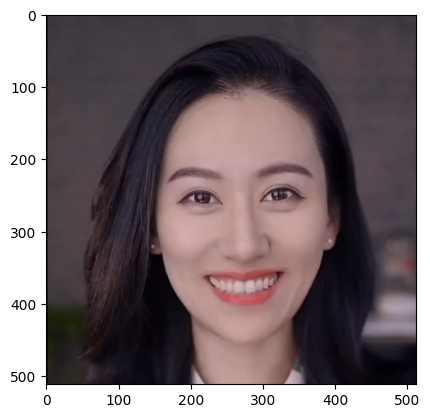

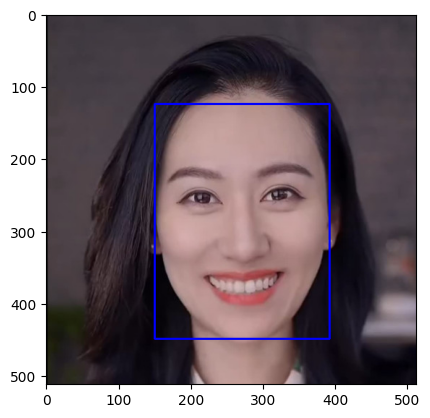

In [2]:
%matplotlib inline

import cv2
import numpy as np
from PIL import Image
from  matplotlib import pyplot as plt

from paddle.fluid.core import AnalysisConfig, PaddleTensor
from paddle.fluid.core import create_paddle_predictor

def pre_det(org_im, shrink):
    image = org_im.copy()
    image_height, image_width, image_channel = image.shape

    # 图像缩放
    if shrink != 1:
        image_height, image_width = int(image_height * shrink), int(
            image_width * shrink)
        image = cv2.resize(image, (image_width, image_height),
                           cv2.INTER_NEAREST)
    # HWC to CHW
    if len(image.shape) == 3:
        image = np.swapaxes(image, 1, 2)
        image = np.swapaxes(image, 1, 0)

    # 归一化
    mean = [104., 117., 123.]
    scale = 0.007843
    image = image.astype('float32')
    image -= np.array(mean)[:, np.newaxis, np.newaxis].astype('float32')
    image = image * scale
    image = np.expand_dims(image, axis=0).astype('float32')
    return image

def post_det(img, output_datas):
    img_h, img_w = img.shape[:2]
    new_img = img.copy()
    crops = []
    for data in output_datas:
        label, score, x1, y1, x2, y2 = data
        if score>0.8:
            x1, y1, x2, y2 = [int(_) for _ in [x1*img_w, y1*img_h, x2*img_w, y2*img_h]]
            crop = img[max(0, y1-50):min(y2+50,img_h),max(0, x1-50):min(x2+50,img_w),:]
            h, w = crop.shape[:2]
            crop = cv2.resize(crop, (200, int(h/w*200))) if w>h else cv2.resize(crop, (int(w/h*200), 200))
            row_nums = 200-crop.shape[0]
            line_nums = 200-crop.shape[1]
            if row_nums%2 ==0:
                crop= np.pad(crop,((row_nums//2,row_nums//2),(0,0),(0,0)),'constant')
            else:
                crop= np.pad(crop,((row_nums//2,row_nums//2+1),(0,0),(0,0)),'constant')
            if line_nums%2 ==0:
                crop= np.pad(crop,((0,0),(line_nums//2,line_nums//2),(0,0)),'constant')
            else:
                crop= np.pad(crop,((0,0),(line_nums//2,line_nums//2+1),(0,0)),'constant')
            crops.append(crop)
            cv2.rectangle(new_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    return new_img, crops

def create_predictor(model_file, params_file):
    # 创建配置
    config = AnalysisConfig(model_file, params_file)
    # 开启mkldnn加速intel平台的CPU推理速度
    # 关闭log显示
    config.disable_glog_info()
    # 开启ir优化
    config.switch_ir_optim(True)
    # 使用feed和fetch的算子
    config.switch_use_feed_fetch_ops(True)
    # 根据配置创建预测器
    predictor = create_paddle_predictor(config)
    return predictor

# 模型预测
def predict_det(predictor, inputs):
    # 转换输入数据为PaddleTensor
    inputs = PaddleTensor(inputs.copy())
    # 执行前向计算
    result = predictor.run([inputs])
    # 转换输出数据为ndarray
    output_data = result[0].as_ndarray()
    return output_data

predictor = create_predictor('inference/face_detect/face_detector.pdmodel', 'inference/face_detect/face_detector.pdiparams')

# 读取图片
img = cv2.imread('0007.jpg')

# 原始图片展示
plt.imshow(img[:,:,::-1])
plt.show()

# 图像预处理
img1 = pre_det(img, 0.5)

# 模型预测
output_data = predict_det(predictor, img1)

# 结果后处理
img, crops = post_det(img, output_data)

# 结果图片展示
plt.imshow(img[:,:,::-1])
plt.show()

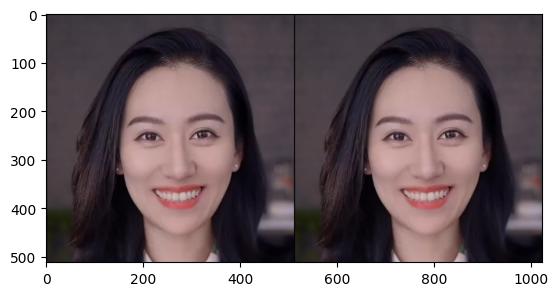

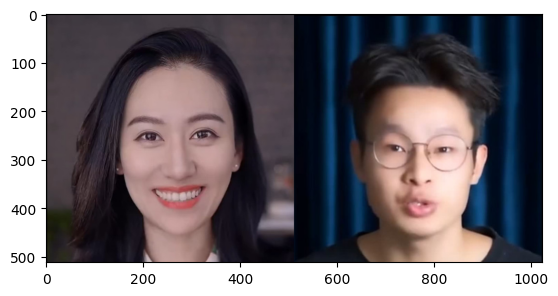

第1个样本不匹配
第2个样本不匹配


In [4]:
%matplotlib inline

import cv2
import numpy as np
from PIL import Image
from  matplotlib import pyplot as plt

from paddle.fluid.core import AnalysisConfig
from paddle.fluid.core import create_paddle_predictor

# 图片拼接
def concatenate(true_img, crop):
    new = np.concatenate([true_img,crop],1)
    return new

# 数据预处理
def pre_val(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)

    # 图像缩放
    image = img.resize((224, 224), Image.LANCZOS)

    # HWC to CHW
    mean = np.array([0.485,0.456,0.406]).reshape(3, 1, 1)
    std = np.array([0.229,0.224,0.225]).reshape(3, 1, 1)
    image = np.array(image).astype('float32')
    if len(image.shape) == 3:
        image = np.swapaxes(image, 1, 2)
        image = np.swapaxes(image, 1, 0)

    # 归一化
    image /= 255
    image -= mean
    image /= std
    image = image[[0, 1, 2], :, :]
    image = np.expand_dims(image, axis=0).astype('float32')
    return image

# 创建预测器
def create_predictor(model_file, params_file):
    # 创建配置
    config = AnalysisConfig(model_file, params_file)
    # 关闭log显示
    config.disable_glog_info()
    # 开启ir优化
    config.switch_ir_optim(True)
    # 不使用feed和fetch的算子
    config.switch_use_feed_fetch_ops(False)
    # 根据配置创建预测器
    predictor = create_paddle_predictor(config)
    return predictor

# 模型预测
def predict_val(predictor, inputs):
    # 获取输入向量名
    input_names = predictor.get_input_names()
    # 根据输入向量名获取输入向量
    input_tensor = predictor.get_input_tensor(input_names[0])
    # 将输入数据拷贝进输入向量
    input_tensor.copy_from_cpu(inputs)
    # 执行前向计算
    predictor.zero_copy_run()
    # 获取输出向量名
    output_names = predictor.get_output_names()
    # 根据输出向量名获取输出向量
    output_tensor = predictor.get_output_tensor(output_names[0])
    # 从输出向量中拷贝输出数据到输出变量上
    output_data = output_tensor.copy_to_cpu()
    return output_data

# 实例化检测模型预测器
predictor = create_predictor('inference/face_compare/resnet50_vd_imagenet_ssld.pdmodel', 'inference/face_compare/resnet50_vd_imagenet_ssld.pdiparams')

# 读取图片
img1 = cv2.imread('0007.jpg')
img2 = cv2.imread('0001.jpg')

# 图像拼接
img_true = concatenate(img1, img1)
img_false = concatenate(img1, img2)

# 输入图片展示
plt.imshow(img_true[:,:,::-1])
plt.show()
plt.imshow(img_false[:,:,::-1])
plt.show()

# 数据预处理
img_true = pre_val(img_true)
img_false = pre_val(img_false)

# 数据拼接
imgs = np.concatenate([img_true, img_false], 0)

# 模型预测
output_data = predict_val(predictor, imgs)

# 结果后处理
results = np.argmax(output_data, 1)

for i, result in enumerate(results):
    if result:
        print('第%d个样本匹配' % (i+1))
    else:
        print('第%d个样本不匹配' % (i+1))